epoch 0/5, step 0/938, loss =2.2946619987487793
epoch 0/5, step 100/938, loss =0.4210563004016876
epoch 0/5, step 200/938, loss =0.17257994413375854
epoch 0/5, step 300/938, loss =0.5265520215034485
epoch 0/5, step 400/938, loss =0.16109636425971985
epoch 0/5, step 500/938, loss =0.19090695679187775
epoch 0/5, step 600/938, loss =0.1260833740234375
epoch 0/5, step 700/938, loss =0.1142624244093895
epoch 0/5, step 800/938, loss =0.26901161670684814
epoch 0/5, step 900/938, loss =0.14273668825626373
epoch 1/5, step 0/938, loss =0.08876672387123108
epoch 1/5, step 100/938, loss =0.20505064725875854
epoch 1/5, step 200/938, loss =0.06080969423055649
epoch 1/5, step 300/938, loss =0.1484047770500183
epoch 1/5, step 400/938, loss =0.1599375456571579
epoch 1/5, step 500/938, loss =0.10107311606407166
epoch 1/5, step 600/938, loss =0.05722835659980774
epoch 1/5, step 700/938, loss =0.1620246320962906
epoch 1/5, step 800/938, loss =0.34333518147468567
epoch 1/5, step 900/938, loss =0.0651284381

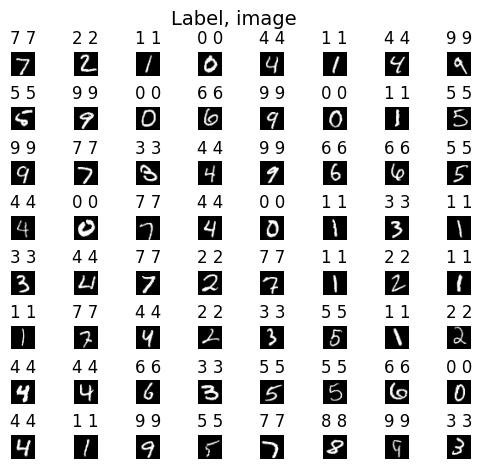

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

# Download the dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

# separate data and targets for both test and train
train_set = train_dataset.data
train_labels = train_dataset.targets
test_set = test_dataset.data
test_labels = test_dataset.targets

# transform the input data by normalizing to under a specific range
# using numpy 
def transform(x):
    data = x.numpy()
    data = (data - data.mean()) / data.std()
    return torch.tensor(data, dtype=torch.float32)

# calling transform function
train_set = transform(train_set)
test_set = transform(test_set)

# Make a class by inheriting from the base class nn.Module
# The first hidden layer has 784 input neurons and 80 output neurons
# The second hidden layer has 80 input neurons and 40 output neurons
# The third hidden layer has 40 input neurons and 10 output neurons
# we define forward function which used to predict the input data 
# We use relu as the activation function to learn complex patterns by introducing non-linearity from the data
# for the last layer we won't use any activation function becuase it can be done by our loss function
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.l1 = nn.Linear(784, 80)
        self.l2 = nn.Linear(80, 40)
        self.l3 = nn.Linear(40, 10)

    def forward(self, x):
        x.view(-1, 28, 28)
        output = torch.relu(self.l1(x))
        output = torch.relu(self.l2(output))
        output = self.l3(output)
        return output

# Convert train_set and test_set to TensorDataset
train_dataset = TensorDataset(train_set.view(-1, 28*28), train_labels)
test_dataset = TensorDataset(test_set.view(-1, 28*28), test_labels)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# creating object by assigning class
model_fcnn = FCNN()

# learning rate defines the step size 
learning_rate = 0.001

# We use cross entropy loss which is a softmax function used for multi classification
criterion = nn.CrossEntropyLoss()

# We use the Adam optimizer, which is an adaptive learning rate optimization algorithm.
optimizer = torch.optim.Adam(model_fcnn.parameters(), lr=learning_rate)

# set the epoch to 5 to iterate over the train dataset
epochs = 5

# Iterate over each epoch in the training process
# Iterate over each batch in the training data

for epoch in range(epochs):
    for idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero the gradients to prevent accumulation from previous iterations
        y_hat = model_fcnn(data) # Forward pass: compute predictions using the model
        loss = criterion(y_hat, labels)  # Compute the loss between the predictions and the labels
        loss.backward() # Backward pass: compute gradients of the loss with respect to model parameters
        optimizer.step() # Update model parameters using the gradients
        
        if idx % 100 == 0:
            print(f'epoch {epoch}/{epochs}, step {idx}/{len(train_loader)}, loss ={loss.item()}')

model_fcnn.eval()
flag = True
with torch.no_grad():
    correct =0
    samples=0
    for idx,(data, labels) in enumerate(test_loader):
        output = model_fcnn(data)
        _,result = torch.max(output,1)
        samples+=labels.shape[0]
        correct+=(result==labels).sum().item()
        if flag:  # to plot first batch along with predicted labels and ground-with labels
            fig, axes = plt.subplots(8,8, figsize=(5,5))
            fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91])  
            for i,ax in enumerate(axes.flat):
                image = data[i].reshape((28,28))
                ax.imshow(image, cmap='gray')
                if result[i]!=labels[i]:
                    ax.set_title(f'{result[i]} {labels[i]}', c='red')
                else:
                    ax.set_title(f'{result[i]} {labels[i]}')
                ax.set_axis_off()
                fig.suptitle("Label, image", fontsize=14)
                flag= False

print(f'Accuracy of the network on the 10000 test images: {100 * correct / samples}%')


In [5]:
import torchvision
from torch import optim
# Define the CNN model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Define the pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Define the fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 80)
        self.fc2 = nn.Linear(80, 10)

    # Define the forward pass
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the transformations for data preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Load the testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


model_cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn.parameters(), lr=0.001, momentum=0.9)

# Train the model
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        # print(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}")
            running_loss = 0.0


model_cnn.eval()
flag = True
with torch.no_grad():
    correct =0
    samples=0
    for idx,(data, labels) in enumerate(testloader):
        
        output = model_cnn(data)
        _,result = torch.max(output,1)
        samples+=labels.shape[0]
        correct+=(result==labels).sum().item()
    print(f'The accuracy for the test set is {100*correct/samples}')
    

Epoch 1, Batch 100, Loss: 2.250
Epoch 1, Batch 200, Loss: 1.982
Epoch 1, Batch 300, Loss: 1.217
Epoch 1, Batch 400, Loss: 0.643
Epoch 1, Batch 500, Loss: 0.452
Epoch 1, Batch 600, Loss: 0.385
Epoch 1, Batch 700, Loss: 0.357
Epoch 1, Batch 800, Loss: 0.316
Epoch 1, Batch 900, Loss: 0.302
Epoch 2, Batch 100, Loss: 0.259
Epoch 2, Batch 200, Loss: 0.245
Epoch 2, Batch 300, Loss: 0.237
Epoch 2, Batch 400, Loss: 0.220
Epoch 2, Batch 500, Loss: 0.208
Epoch 2, Batch 600, Loss: 0.190
Epoch 2, Batch 700, Loss: 0.187
Epoch 2, Batch 800, Loss: 0.182
Epoch 2, Batch 900, Loss: 0.189
Epoch 3, Batch 100, Loss: 0.161
Epoch 3, Batch 200, Loss: 0.160
Epoch 3, Batch 300, Loss: 0.142
Epoch 3, Batch 400, Loss: 0.144
Epoch 3, Batch 500, Loss: 0.125
Epoch 3, Batch 600, Loss: 0.130
Epoch 3, Batch 700, Loss: 0.143
Epoch 3, Batch 800, Loss: 0.122
Epoch 3, Batch 900, Loss: 0.112
Epoch 4, Batch 100, Loss: 0.117
Epoch 4, Batch 200, Loss: 0.107
Epoch 4, Batch 300, Loss: 0.108
Epoch 4, Batch 400, Loss: 0.104
Epoch 4,

In [4]:
image_path ='WhatsApp Image 2024-03-24 at 02.48.02_464c5bd6.jpg'
image_path ='input_image3.jpg'
image = Image.open(image_path)
# image.show()

torch.Size([1, 1, 28, 28])


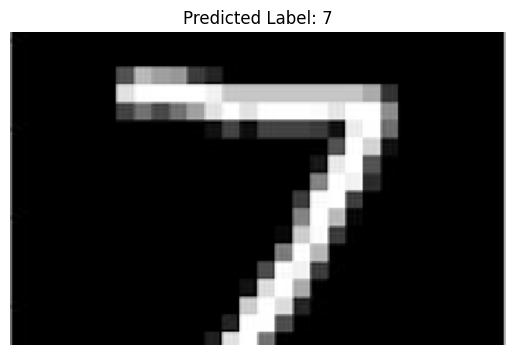

In [83]:
def predict_and_plot(image_path, model):
    image = Image.open(image_path).convert('L')
    transform = transforms.Compose([
        transforms.Resize((28, 28)),  
        transforms.ToTensor(),       
        transforms.Normalize((0.1307,), (0.3081,))  
    ])
    image_tensor = transform(image)  
    image_tensor = image_tensor.unsqueeze(0)    
    print(image_tensor.shape)
    with torch.no_grad():
        output = model(image_tensor)
        predicted_label = torch.argmax(output).item()
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Label: {predicted_label}")
    plt.axis('off')
predict_and_plot('input_image7.jpg', model=model_cnn)

torch.Size([1, 784])


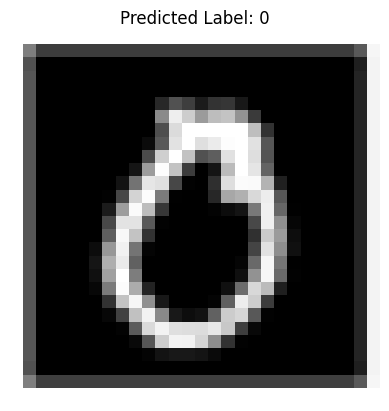

In [71]:
def predict_and_plot(image_path, model):
    image = Image.open(image_path).convert('L')
    image_resized = image.resize((28, 28), Image.BICUBIC)  
    image_array = np.array(image_resized).reshape(-1, 784)
    transform = transforms.Compose([
        transforms.ToTensor(),        
        transforms.Normalize((0.1307,), (0.3081,)) 
    ])
    image_tensor = torch.tensor(image_array, dtype=torch.float)
    print(image_tensor.shape) 
    with torch.no_grad():
        output = model(image_tensor)
        predicted_label = torch.argmax(output).item()
    plt.imshow(image_resized, cmap='gray')
    plt.title(f"Predicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()
predict_and_plot('mnist_0.jpeg', model=model_fcnn)

In [ ]:
image.show()